In [1]:
import re,os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython.display import clear_output
import pandas as pd
import math
import random
from datetime import datetime
from tqdm import trange
import matplotlib.colors as mcolors
from sklearn.decomposition import PCA
import plotly.express as px
import plotly.graph_objects as go
from ipywidgets import widgets
import plotly.graph_objects as go
tfk = tf.keras
tfkl = tf.keras.layers
tfkltd= tf.keras.layers.TimeDistributed
clear_output()
os.environ["CUDA_VISIBLE_DEVICES"]="7"

In [2]:
from generate import generate
from latent import latent
from plot_training import plot_training
from plot_save import plot_save
import symae_core as symae

Num GPUs Available:  2
TensorFlow Version:  2.9.1


In [3]:
n1 = 2
n2 = 2
nx = 10
nt = 2
p = 1
q = 10
dropout_rate = 0.0
states = np.arange(n1)+1.0
nuisances = np.arange(n2)+1.0

In [4]:
data = generate(states,nuisances,nx,nt,replace=2)
X = data.X
X_states = data.X_states
X_nuisances = data.X_nuisances

In [5]:
class SymmetricEncoderDense0D(tf.keras.Model):
    def __init__(self, p, nt):
        super(SymmetricEncoderDense0D, self).__init__(name='')
        self.nt_out=p
        self.nt_in=nt
        self.d1=tfkltd(tfkl.Dense(4,activation=tf.keras.layers.LeakyReLU()))
        self.d2=tfkltd(tfkl.Dense(16,activation=tf.keras.layers.LeakyReLU()))
        self.d3=tfkl.Dense(16,activation=tf.keras.layers.LeakyReLU())
        self.d4=tfkl.Dense(4,activation=tf.keras.layers.LeakyReLU())
        self.d5=tfkl.Dense(p)
    def call(self, x, training=False):
        x=self.d1(x)
        x=self.d2(x)
        x=tf.math.reduce_mean(x,axis=1)
        x=self.d3(x)
        x=self.d4(x)
        x=self.d5(x)
        return x
# 你是在让 nuisance encoder 记住states
class NuisanceEncoderDense0D(tf.keras.Model):
    def __init__(self, q, nt):
        super(NuisanceEncoderDense0D, self).__init__(name='')
        self.d1=tfkl.Dense(4,activation=tf.keras.layers.LeakyReLU())
        self.d2=tfkl.Dense(16,activation=tf.keras.layers.LeakyReLU())
        self.d3=tfkl.Dense(64,activation=tf.keras.layers.LeakyReLU())
        self.d4=tfkl.Dense(16,activation=tf.keras.layers.LeakyReLU())
        self.d5=tfkl.Dense(4,activation=tf.keras.layers.LeakyReLU())
        self.d6=tfkl.Dense(q)
    def call(self, input_tensor, training=False):
        x=self.d1(input_tensor)
        x=self.d2(x)
        x=self.d3(x)
        x=self.d4(x)
        x=self.d5(x)
        x=self.d6(x)
        return x
class DistributeZsym(tf.keras.Model):
    def __init__(self, ntau, nz0, nzi):
        super(DistributeZsym, self).__init__(name='')
        self.nz0=nz0
        self.nzi=nzi
        self.ntau=ntau
        self.ri=tfkl.Reshape(target_shape=(ntau,nzi))
        self.repeat=tfkl.RepeatVector(ntau)
    def call(self, z, training=False):
        z0,zi=tf.split(z,[self.nz0, self.ntau*self.nzi],axis=1)
        zi=self.ri(zi)
        z0=self.repeat(z0)
        out=tfkl.concatenate([z0, zi],axis=2)
        return out
class MixerDense0D(tf.keras.Model):
    def __init__(self, n_out=1, n_in=p+q):
        super(MixerDense0D, self).__init__(name='')
        self.d1=tfkl.Dense(4*(n_in),activation=tf.keras.layers.LeakyReLU())
        self.d2=tfkl.Dense(n_in,activation=tf.keras.layers.LeakyReLU())
        self.d3=tfkl.Dense(4,activation=tf.keras.layers.LeakyReLU())
        self.d4=tfkl.Dense(2,activation=tf.keras.layers.LeakyReLU())
        self.d5=tfkl.Dense(1,activation=tf.keras.layers.LeakyReLU())
        self.d6=tfkl.Dense(1)
    def call(self, z, training=False):
        x=self.d1(z)
        x=self.d2(x)
        x=self.d3(x)
        x=self.d4(x)
        x=self.d5(x)
        x=self.d6(x)
        return x

In [6]:
class LatentCat(tf.keras.Model):
    def __init__(self, alpha=1.0):
        super(LatentCat, self).__init__(name='')
        self.drop = tfkl.Dropout(alpha)
        #self.drop = tfkl.GaussianDropout(alpha)
        #self.my_drop = My_Dropout(int((1-alpha)*q))
    def call(self, zsym, znuisance, training=False):
        #tf.print(training)
        znuisance = self.drop(znuisance, training=training)
        znuisance = tfkl.Flatten()(znuisance)
        z = tfkl.concatenate([zsym, znuisance])
        return z

In [7]:
class SymAE(tf.keras.Model):
    def __init__(self, N, nt, p, q, dropout_rate): 
        super(SymAE, self).__init__()
        # Build symmetric encoder
        sym_encoder = SymmetricEncoderDense0D(p,nt)
        sym_encoder._name = 'sym_encoder'
        self.sym_encoder=sym_encoder
        # Build nuisance encoder
        nui_encoder = NuisanceEncoderDense0D(q,nt)
        nui_encoder._name = 'nui_encoder'
        self.nui_encoder = nui_encoder
        #Build latentcat
        latentcat = LatentCat(alpha=dropout_rate)
        latentcat._name = 'latentcat'
        self.latentcat = latentcat  
        # Build distribute in decoder
        distzsym = DistributeZsym(nt, p, q)
        distzsym._name = 'dist'
        self.distzsym = distzsym
        #Build mixer in decoder
        mixer = MixerDense0D(1,p+q)
        mixer._name = 'mixer'
        self.mixer = mixer
        # Build encoder
        encoder_input = tfk.Input(shape=(nt,1), dtype='float32', name='encoder_input')
        znuisance = nui_encoder(encoder_input)
        zsym = sym_encoder(encoder_input)
        encoder_output=latentcat(zsym,znuisance)
        encoder=tfk.Model(encoder_input, encoder_output, name="encoder")
        self.encoder=encoder
        # Build decoder
        decoder_input = tfk.Input(shape=(p+q*nt), name='latentcode')
        decoder_output=mixer(distzsym(decoder_input))
        decoder=tfk.Model(decoder_input,decoder_output, name="decoder") 
        self.decoder=decoder
    def call(self, input_tensor, training=False):
        return self.decoder(self.encoder(input_tensor))

In [8]:
Adam = tf.keras.optimizers.Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999,epsilon=1e-07)
mse = tf.keras.losses.MeanSquaredError()
def redatum(X1, X2):
    return model.decoder(model.latentcat(model.sym_encoder(X1), model.nui_encoder(X2)))

For epoch 9999, loss is 0.000557.
Redatuming loss 1.302884.


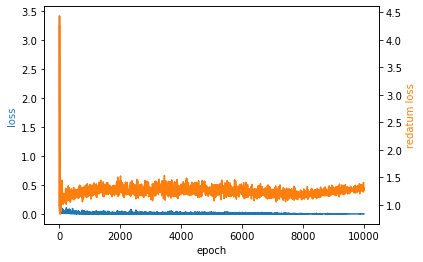

In [16]:
for q in range(2,50):
    model = SymAE(nx,nt,p,q,0.5)
    model.compile(loss='mse',optimizer=Adam)
    M=10000
    epochs=range(M)
    losses=[np.nan]*M
    redata=[np.nan]*M
    sample_size = 10
    redatum_list = list(zip(np.random.randint(0,nx,sample_size),np.random.randint(0,nx,sample_size)))
    @tf.function
    def redatum_loss(X):
        s = []
        for (i1,i2) in redatum_list:
            X1 = X[i1:i1+1]
            X2 = X[i2:i2+1]
            s.append(mse(redatum(X1,X2), states[X_states[i1]]*nuisances[X_nuisances[i2,:]]))
        #tf.print(redatum(X1,X2))
        return sum(s)/sample_size
    class CustomCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs=None):
            clear_output(wait=True)
            losses[epoch]=logs["loss"]
            redata[epoch] = redatum_loss(X)
            print("For epoch {:d}, loss is {:f}.".format(epoch, logs["loss"]))
            print("Redatuming loss {:f}.".format(redata[epoch]))
    history=model.fit(X,X,epochs=M,verbose=0,callbacks=[CustomCallback()])
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(epochs,losses,'C0')
    ax2.plot(epochs,redata,'C1')
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('loss', color='C0')
    ax2.set_ylabel('redatum loss', color='C1')
    plt.show()
    fig.savefig('./q=%d,redatum_loss=%f.jpg'%(q,min(redata)))

In [45]:
import os
pic=[]
qs=[]
ls=[]
for file in os.listdir("./"):
    if file.endswith(".jpg"):
        pic.append(file)
        matchObj = re.match("q=(.*),redatum_loss=(.*).jpg", pic[-1], flags=0)
        qs.append(int(matchObj[1]))  
        ls.append(float(matchObj[2]))

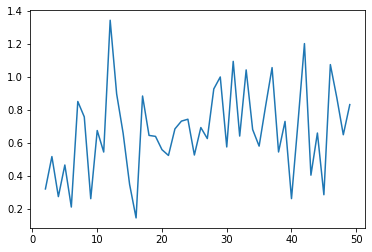

In [46]:
plt.plot(qs,ls)

0.32155